In [1]:
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import PIL

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchsummary import summary

import torchvision
from torchvision import datasets, models, transforms
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
#from albumentations.pytorch import ToTensor


# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Loading Data

## Transform data

In [3]:
data_tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.Resize(400),
    transforms.RandomCrop(256),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

In [4]:
from dataset import BuildingsDataset

In [5]:
dataset = BuildingsDataset(
    img_dir='data/labels/',
    transform=data_tranform,
)

## Displaying samples

In [6]:
from show import show_labeled_img

(256, 256, 3) (256, 256, 1)


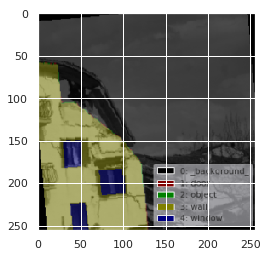

In [7]:
data = dataset[0]
show_labeled_img(data['image'], data['label'], dataset.label_name_to_value)

# Using AlbuNet

In [8]:
from models import AlbuNet

In [32]:
albunet = AlbuNet(
    num_classes=len(dataset.label_name_to_value),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
)
#model.to(device);

## Model details

In [33]:
%%capture catching_output
summary(albunet, input_size=(3, 128, 128))

In [34]:
summary_txt = catching_output.stdout
%store summary_txt > "models_summary/albunet_summary.txt"

Writing 'summary_txt' (str) to file 'models_summary/albunet_summary.txt'.


In [35]:
separator = "=" * 10
counter = 0
for l in iter(summary_txt.splitlines()):
    if separator in l:
        counter += 1
    if counter > 1:
        print(l)

Total params: 47,466,965
Trainable params: 47,466,965
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 136.94
Params size (MB): 181.07
Estimated Total Size (MB): 318.20
----------------------------------------------------------------


In [36]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [37]:
def to_dataloader(dataset):
    return DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [38]:
train_data, val_data = torch.utils.data.random_split(dataset, lenghts_split(len(dataset), 0.9))
dataloaders = {'train': to_dataloader(train_data), 'val': to_dataloader(val_data)}

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device)
                labels = sample['label'].squeeze().to(device)
                print(inputs.shape, labels.shape)
                print(set(labels.numpy().flatten()))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

albunet = train_model(albunet, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{0, 1, 2, 3, 4}
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
{

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/lib/python3.6/multiprocessing/

KeyboardInterrupt: 

# CODE TAKEN FROM TUTORIAL

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()